# Notes of Google ML Crash Course

Disclaimer: This notebook summarizes the programming exercises from the Google ML crash course. Note that we will being using Tensorflow 1.x APIs throughout the notebook. Almost all of the code and the descriptions are taken from the various notebooks in that course. Little, if any, of the material is original except perhaps the point of views.

In [4]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

TensorFlow 1.x selected.


## First Model: Single Feature Linear Regression with SGD

For most of our discussions, we will be looking the California housing price data set. Let's first load the data set into a Panda dataframe:

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

We'll randomize the data, just to be sure not to get any pathological ordering effects that might harm the performance of Stochastic Gradient Descent. Additionally, we'll scale `median_house_value` to be in units of thousands, so it can be learned a little more easily with learning rates in a range that we usually use.

In [3]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
9706,-119.6,36.7,18.0,1284.0,193.0,621.0,190.0,4.5,130.6
16803,-123.2,39.1,30.0,1904.0,331.0,816.0,325.0,4.4,161.9
5390,-118.2,33.9,38.0,901.0,205.0,760.0,208.0,3.0,147.4
11037,-121.0,37.6,36.0,60.0,12.0,51.0,14.0,3.6,67.5
13005,-121.8,36.6,41.0,3138.0,717.0,1890.0,642.0,2.5,140.4
...,...,...,...,...,...,...,...,...,...
10989,-120.9,37.7,37.0,1956.0,402.0,1265.0,397.0,2.3,91.9
8819,-118.7,34.3,10.0,3753.0,678.0,1859.0,660.0,5.0,204.6
13488,-122.0,38.0,35.0,2691.0,542.0,1409.0,505.0,3.0,95.3
16689,-122.8,38.1,19.0,1615.0,366.0,815.0,337.0,3.5,238.8


We first print out some of the statistics of the dataset to get a better feel of what we are working with.

In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


Suppose our goal is to predict the `median_house_value`. This is a regression problem. We can use the [LinearRegressor](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearRegressor) interface provided by the TensorFlow [Estimator](https://www.tensorflow.org/get_started/estimator) API. This API takes care of a lot of the low-level model plumbing, and exposes convenient methods for performing model training, evaluation, and inference.

### Step 1: Define Features and Configure Feature Columns

In order to import our training data into TensorFlow, we need to specify what type of data each feature contains. There are two main types of data we'll use in this and future exercises:

* **Categorical Data**: Data that is textual. In this exercise, our housing data set does not contain any categorical features, but examples you might see would be the home style, the words in a real-estate ad.

* **Numerical Data**: Data that is a number (integer or float) and that you want to treat as a number. As we will discuss more later sometimes you might want to treat numerical data (e.g., a postal code) as if it were categorical (e.g., when we want to ignore the ordinal relationships between the numerical values).

In TensorFlow, we indicate a feature's data type using a construct called a **feature column**. **Feature columns store only a description of the feature data; they do not contain the feature data itself**.

To start, we're going to use just one numeric input feature, `total_rooms`. The following code pulls the `total_rooms` data from our `california_housing_dataframe` and defines the feature column using `numeric_column`, which specifies its data is numeric:

In [0]:
# Define the input feature: total_rooms.
my_feature = california_housing_dataframe[["total_rooms"]]

# Configure a numeric feature column for total_rooms.
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [7]:
feature_columns

[NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

### Step 2: Define the Target

In [8]:
# Define the label.
targets = california_housing_dataframe["median_house_value"]
targets

9706    130.6
16803   161.9
5390    147.4
11037    67.5
13005   140.4
         ... 
10989    91.9
8819    204.6
13488    95.3
16689   238.8
5855    160.0
Name: median_house_value, Length: 17000, dtype: float64

### Step 3: Configure the LinearRegressor

Next, we'll configure a linear regression model using LinearRegressor. We'll train this model using the `GradientDescentOptimizer`, which implements Mini-Batch Stochastic Gradient Descent (SGD). The `learning_rate` argument controls the size of the gradient step.

**NOTE:** To be safe, we also apply [gradient clipping](https://developers.google.com/machine-learning/glossary/#gradient_clipping) to our optimizer via `clip_gradients_by_norm`. **Gradient clipping ensures the magnitude of the gradients do not become too large during training, which can cause gradient descent to fail**. 

In [0]:
# Use gradient descent as the optimizer (i.e. the algorithm) for training the model.
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

# Configure the linear regression model with our feature columns and optimizer.
# Set a learning rate of 0.0000001 for Gradient Descent.
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    optimizer=my_optimizer
)

### Step 4: Define the Input Function

To import our California housing data into our `LinearRegressor`, we need to define an input function, which instructs TensorFlow __how to preprocess
the data, as well as how to batch, shuffle, and repeat it during model training__.

First, we'll convert our *pandas* feature data into a dict of NumPy arrays. We can then use the TensorFlow [Dataset API](https://www.tensorflow.org/programmers_guide/datasets) to construct a TF dataset object from our data, and then break
our data into batches of `batch_size`, to be repeated for the specified number of epochs (num_epochs). 

**NOTE:** `num_epochs` is the number of times we loop through the entire training set. When the default value of `num_epochs=None` is passed to `repeat()`, the input data will be repeated indefinitely.

Next, if `shuffle` is set to `True`, we'll shuffle the data so that it's passed to the model randomly during training. The `buffer_size` argument specifies
the size of the dataset from which `shuffle` will randomly sample.

Finally, our input function constructs an iterator for the dataset and returns the next batch of data to the LinearRegressor.

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Input function to process input data to feed to models
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(buffer_size=10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

**NOTE:** We'll continue to use this same input function in later exercises. For more
detailed documentation of input functions and the `Dataset` API, see the [TensorFlow Programmer's Guide](https://www.tensorflow.org/programmers_guide/datasets).

### Step 5: Train the Model

We can now call `train()` on our `linear_regressor` to train the model. We'll wrap `my_input_fn` in a `lambda`
so we can pass in `my_feature` and `targets` as arguments (see this [TensorFlow input function tutorial](https://www.tensorflow.org/get_started/input_fn#passing_input_fn_data_to_your_model) for more details), and to start, we'll
train for 100 steps.

In [0]:
_ = linear_regressor.train(
    input_fn = lambda:my_input_fn(my_feature, targets),
    steps=100
)

### Step 6: Evaluate the Model

Let's make predictions on that training data, to see how well our model fit it during training.

**NOTE:** Training error measures how well your model fits the training data, but it **_does not_** measure how well your model **_generalizes to new data_**. In later exercises, you'll explore how to split your data to evaluate your model's ability to generalize.


In [26]:
# Create an input function for predictions.
# Note: Since we're making just one prediction for each example, we don't 
# need to repeat or shuffle the data here.
prediction_input_fn =lambda: my_input_fn(my_feature, targets, num_epochs=1, shuffle=False)

# Call predict() on the linear_regressor to make predictions.
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
# Format predictions as a NumPy array, so we can calculate error metrics.
predictions = np.array([item['predictions'][0] for item in predictions])
print(predictions)
# Print Mean Squared Error and Root Mean Squared Error.
mean_squared_error = metrics.mean_squared_error(predictions, targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error (on training data): %0.3f" % mean_squared_error)
print("Root Mean Squared Error (on training data): %0.3f" % root_mean_squared_error)

[0.06420004 0.09520003 0.04505003 ... 0.13455003 0.08075003 0.07370003]
Mean Squared Error (on training data): 56367.025
Root Mean Squared Error (on training data): 237.417


Is this a good model? How would you judge how large this error is?

Mean Squared Error (MSE) can be hard to interpret, so we often look at Root Mean Squared Error (RMSE)
instead. A nice property of RMSE is that it can be interpreted on the same scale as the original targets.

Let's compare the RMSE to the difference of the min and max of our targets:

In [27]:
min_house_value = california_housing_dataframe["median_house_value"].min()
max_house_value = california_housing_dataframe["median_house_value"].max()
min_max_difference = max_house_value - min_house_value

print("Min. Median House Value: %0.3f" % min_house_value)
print("Max. Median House Value: %0.3f" % max_house_value)
print("Difference between Min. and Max.: %0.3f" % min_max_difference)
print("Root Mean Squared Error: %0.3f" % root_mean_squared_error)

Min. Median House Value: 14.999
Max. Median House Value: 500.001
Difference between Min. and Max.: 485.002
Root Mean Squared Error: 237.417


Our error spans nearly half the range of the target values. Can we do better?

This is the question that nags at every model developer. Let's develop some basic strategies to reduce model error.

The first thing we can do is take a look at how well our predictions match our targets, in terms of overall summary statistics.

In [28]:
calibration_data = pd.DataFrame()
calibration_data["predictions"] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


Okay, maybe this information is helpful. How does the mean value compare to the model's RMSE? How about the various quantiles?

We can also visualize the data and the line we've learned.  Recall that linear regression on a single feature can be drawn as a line mapping input *x* to output *y*.

First, we'll get a uniform random sample of the data so we can make a readable scatter plot.

In [0]:
sample = california_housing_dataframe.sample(n=300)

Next, we'll plot the line we've learned, drawing from the model's bias term and feature weight, together with the scatter plot. The line will show up red.

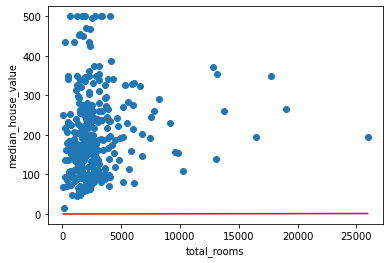

In [30]:
# Get the min and max total_rooms values.
x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

# Retrieve the final weight and bias generated during training.
weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

# Get the predicted median_house_values for the min and max total_rooms values.
y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

# Plot our regression line from (x_0, y_0) to (x_1, y_1).
plt.plot([x_0, x_1], [y_0, y_1], c='r')

# Label the graph axes.
plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

# Plot a scatter plot from our data sample.
plt.scatter(sample["total_rooms"], sample["median_house_value"])

# Display graph.
plt.show()

Our linear model prediction looks way off. Our task for the remainder of this notebook is to improve our model in order to derive at a much better model. We first combine all the above different pieces of functions into a single function for convienence.

In this function, we'll proceed in 10 evenly divided periods so that we can observe the model improvement at each period.

For each period, we'll compute and graph training loss. This may help you judge when a model is converged, or if it needs more iterations.

We'll also plot the feature weight and bias term values learned by the model over time. This is another way to see how things converge.


In [0]:
def train_model(learning_rate, steps, batch_size, input_feature="total_rooms"):
  """Trains a linear regression model of one feature.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    input_feature: A `string` specifying a column from `california_housing_dataframe`
      to use as input feature.
  """
  
  periods = 10
  steps_per_period = steps / periods

  my_feature = input_feature
  my_feature_data = california_housing_dataframe[[my_feature]]
  my_label = "median_house_value"
  targets = california_housing_dataframe[my_label]

  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column(my_feature)]
  
  # Create input functions.
  training_input_fn = lambda:my_input_fn(my_feature_data, targets, batch_size=batch_size)
  prediction_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )

  # Set up to plot the state of our model's line each period.
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  plt.title("Learned Line by Period")
  plt.ylabel(my_label)
  plt.xlabel(my_feature)
  sample = california_housing_dataframe.sample(n=300)
  plt.scatter(sample[my_feature], sample[my_label])
  colors = [cm.coolwarm(x) for x in np.linspace(-1, 1, periods)]

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  root_mean_squared_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    predictions = linear_regressor.predict(input_fn=prediction_input_fn)
    predictions = np.array([item['predictions'][0] for item in predictions])
    
    # Compute loss.
    root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predictions, targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    root_mean_squared_errors.append(root_mean_squared_error)
    # Finally, track the weights and biases over time.
    # Apply some math to ensure that the data and line are plotted neatly.
    y_extents = np.array([0, sample[my_label].max()])
    
    weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
    bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

    x_extents = (y_extents - bias) / weight
    x_extents = np.maximum(np.minimum(x_extents,
                                      sample[my_feature].max()),
                           sample[my_feature].min())
    y_extents = weight * x_extents + bias
    plt.plot(x_extents, y_extents, color=colors[period]) 
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.subplot(1, 2, 2)
  plt.ylabel('RMSE')
  plt.xlabel('Periods')
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(root_mean_squared_errors)

  # Output a table with calibration data.
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  display.display(calibration_data.describe())

  print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)

Training model...
RMSE (on training data):
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.44
  period 03 : 194.97
  period 04 : 187.55
  period 05 : 180.53
  period 06 : 175.88
  period 07 : 171.57
  period 08 : 169.21
  period 09 : 167.62
Model training finished.


,predictions,targets
count,17000.0,17000.0
mean,114.7,207.3
std,94.6,116.0
min,0.1,15.0
25%,63.5,119.4
50%,92.3,180.4
75%,136.8,265.0
max,1646.5,500.0


Final RMSE (on training data): 167.62


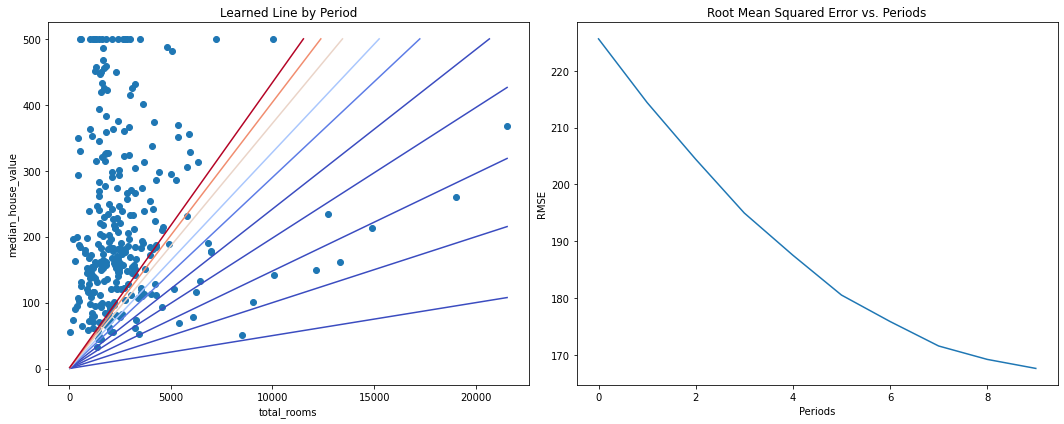

In [33]:
train_model(
    learning_rate=0.00002,
    steps=500,
    batch_size=5
)

### Summary
We have now trained a simple linear regression model in Tensorflow with a single feature to predict the `median_house_value`. In building this model, we have used the following components:
* Feature column: which is a declaration of the features and their types to be used in our model. It specifies the feature names and their types. The trainer (or regressor in this case) will fetch the corresponding feature vector using the input function at run time.
* Input function: This is an API that transforms (Pandas) dataframe input data into Tensorflow Dataset format. It also provides a buffering mechnism so that the data can be fetched in batches, or in shuffled mode. It can also be specified with the number of epochs we need to scan through the data. It basically abstracts away the data loading functionalities for model training/scoring.
* Regressor: A regressor requires both the feature column declarations as well as the optimizer used for training.

## Second Model: Addtional Features

For this section, we are going to expand our model above by using multiple features. We will also start using proper feature and label processing sub-routines. Finally we will incorporate train-validation-test paradigm for more rigorous model building and validation.

### Expository Data Analysis (EDA)
**Debugging in ML is often *data debugging* rather than code debugging.** If the data is wrong, even the most advanced ML code can't save things. We now take a closer look at our dataset.

* For some values, like `median_house_value`, we can check to see if these values fall within reasonable ranges (keeping in mind this was 1990 data — not today!).

* For other values, like `latitude` and `longitude`, we can do a quick check to see if these line up with expected values from a quick Google search.

If you look closely, you may see some oddities:

* `median_income` is on a scale from about 2 to 15. It's not at all clear what this scale refers to—looks like maybe some log scale? It's not documented anywhere; all we can assume is that higher values correspond to higher income.

* The maximum `median_house_value` is 500,001. This looks like an artificial cap of some kind.

* Our `rooms_per_person` feature is generally on a sane scale, with a 75th percentile value of about 2. But there are some very large values, like 18 or 55, which may show some amount of corruption in the data.

We'll use these features as given for now. But hopefully these kinds of examples can help to build a little intuition about how to check data that comes to you from an unknown source.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84108f8c50>,
      dtype=object)

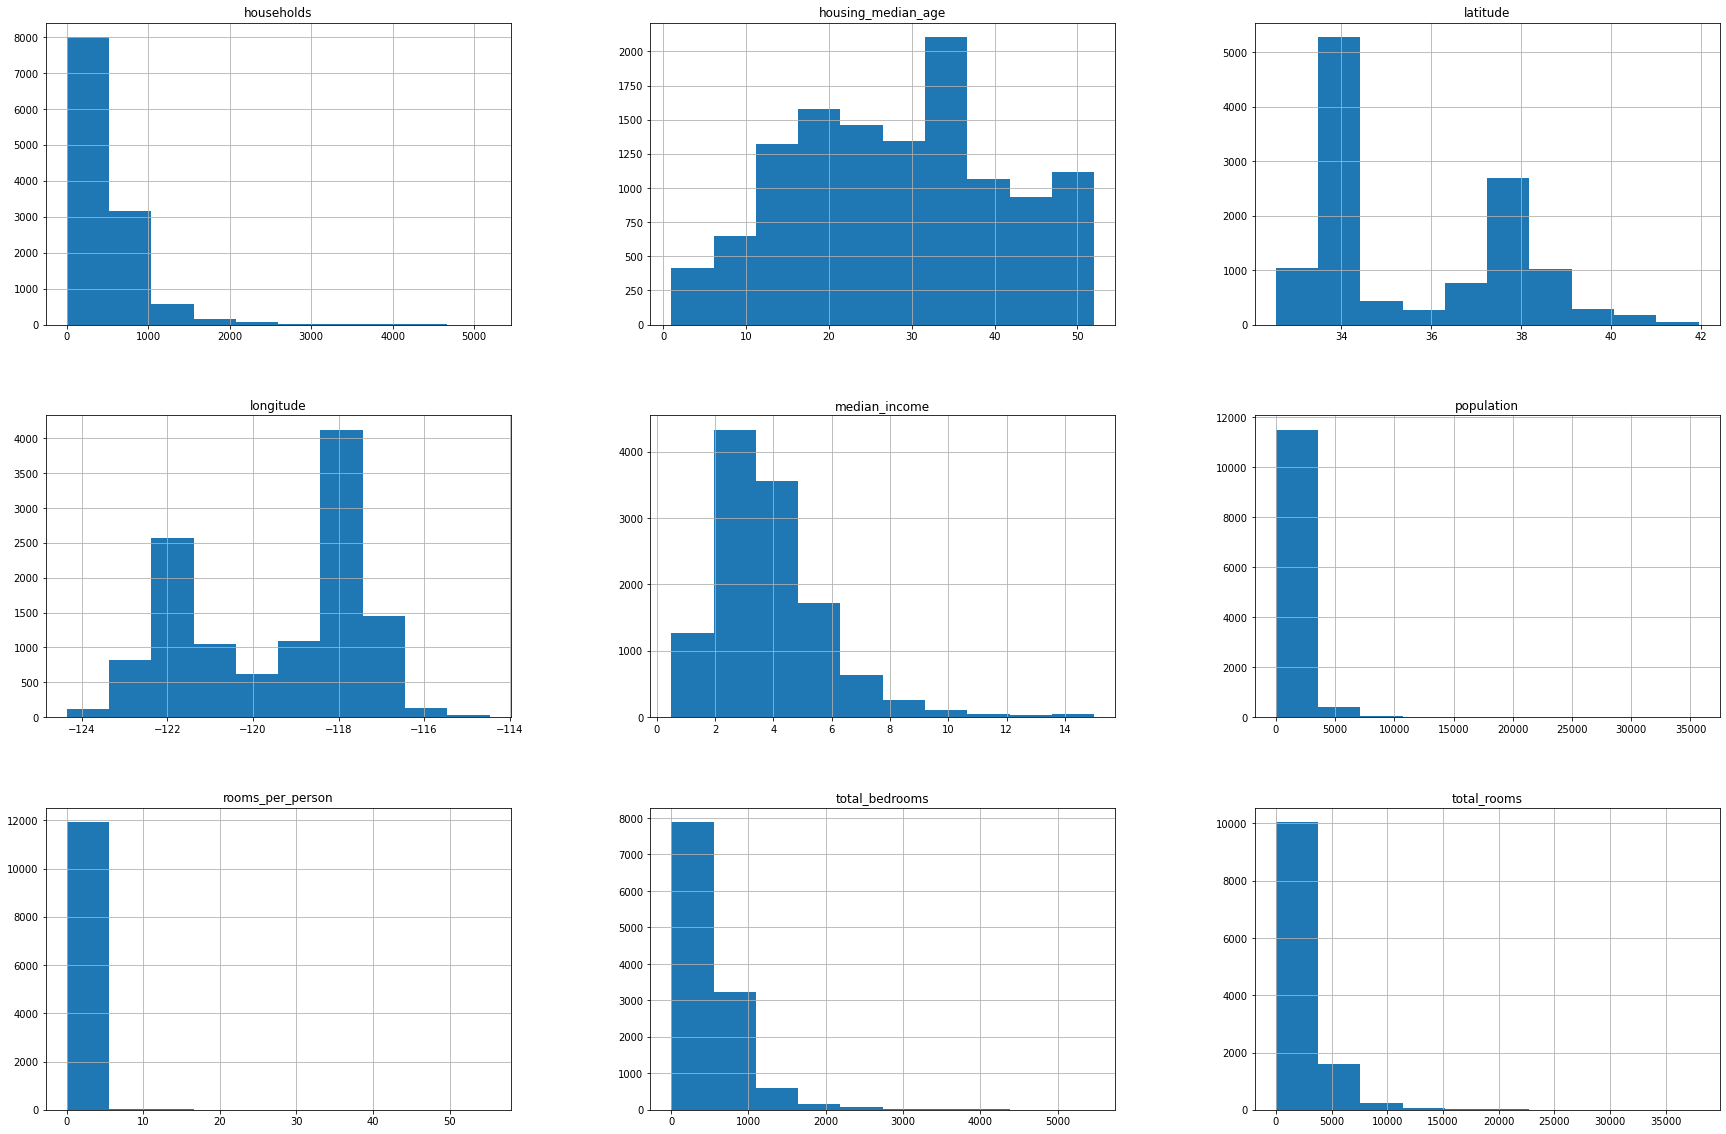

In [44]:
training_examples.hist(figsize=(30,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8411732320>]],
      dtype=object)

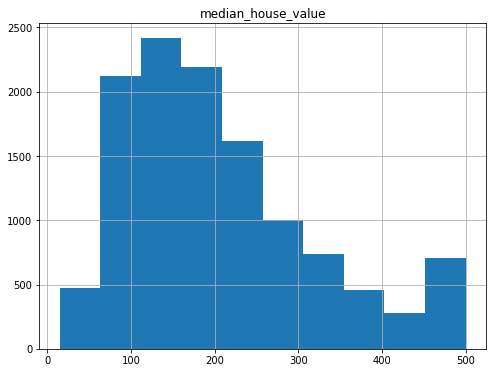

In [48]:
training_targets.hist(figsize=(8,6))

### Model Pipeline Refactor

We now refactor the feature prepration, data loading and model training functions we had in the previous section to be able to hanel multiple features and as a more generic pipeline. We are reusing the `my_input_fn` function.

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

def construct_feature_columns(training_examples):
  """Construct the TensorFlow Feature Columns.

  Args:
    training_examples: Dataframe of training examples from which we extract the feature columns
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(feature_name) for feature_name in training_examples.columns])

def train_linear_regression_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    optimizer,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    feature_columns: A `set` specifying the input feature columns to use.
    optimizer: A `String` to denote the type of optimizer we use. SGD by default.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object and figure out the columns to use on the fly.
  if optimizer == 'FTRL':
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  else:
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets, 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Let's reload the dataset to get a clean start.

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

For the **training set**, we'll choose the first 12000 examples, out of the total of 17000.

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

For the **validation set**, we'll choose the last 5000 examples, out of the total of 17000.

In [0]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

Training model...
RMSE (on training data):
  period 00 : 165.29
  period 01 : 219.21
  period 02 : 185.96
  period 03 : 158.11
  period 04 : 155.32
  period 05 : 160.85
  period 06 : 152.37
  period 07 : 151.97
  period 08 : 199.50
  period 09 : 151.94
Model training finished.


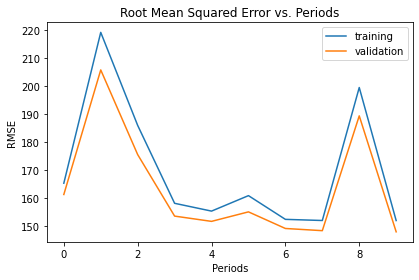

In [14]:
linear_regressor = train_linear_regression_model(
    learning_rate=0.003,
    steps=500,
    batch_size=5,
    feature_columns=construct_feature_columns(training_examples),
    optimizer='SGD',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Evaluate on the Test Data

In [81]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
      test_examples, 
      test_targets["median_house_value"], 
      num_epochs=1, 
      shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)

Final RMSE (on test data): 163.29


### Play With a Smaller Feature Set
Let's try with a smaller feature set and see how well does the model do. Without our pipeline refactor, it is easy to try with a different feature set.

Training model...
RMSE (on training data):
  period 00 : 165.57
  period 01 : 124.57
  period 02 : 118.91
  period 03 : 116.23
  period 04 : 115.56
  period 05 : 115.13
  period 06 : 114.94
  period 07 : 113.79
  period 08 : 113.34
  period 09 : 113.14
Model training finished.


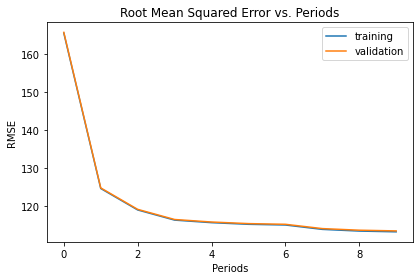

In [85]:
smaller_feature_set = [
  "median_income",
  "latitude",
]

smaller_training_set = training_examples[smaller_feature_set]
smaller_validation_set = validation_examples[smaller_feature_set]

train_linear_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    optimizer='SGD',
    training_examples=smaller_training_set,
    training_targets=training_targets,
    validation_examples=smaller_validation_set,
    validation_targets=validation_targets
)

Interestingly enough, with a smaller set of features, our model is actually doing much better RMSE-wise than before where we used more features.

### Generate More Synthetic Features
Previously we used `rooms_per_person` as a post-generated synthetic features. In practice, one of the most important step in developing a good machine learning model is to engineer good features. More often than not, careful feature engineer can lead to a better performing model than spending time fine-tuning or trying out very complex models. Let's now add some more synthetic features.

Training model...
RMSE (on training data):
  period 00 : 224.96
  period 01 : 212.69
  period 02 : 200.46
  period 03 : 188.45
  period 04 : 176.67
  period 05 : 165.17
  period 06 : 154.00
  period 07 : 143.23
  period 08 : 133.04
  period 09 : 123.51
Model training finished.


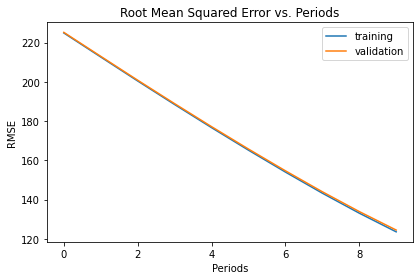

In [86]:
def post_process_features(training_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  selected_training_examples = pd.DataFrame()
  selected_training_examples["median_income"] = training_df["median_income"]
  selected_training_examples["rooms_per_person"] = training_df["rooms_per_person"]
  selected_training_examples["distance_to_san_francisco"] = np.abs(training_df["latitude"] - 38)
  for r in LATITUDE_RANGES:
    selected_training_examples["latitude_%d_to_%d" % r] = training_df["latitude"].apply(lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_training_examples

post_processed_training_features = post_process_features(training_examples)
post_processed_validation_features = post_process_features(validation_examples)

train_linear_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    optimizer='SGD',
    training_examples=post_processed_training_features,
    training_targets=training_targets,
    validation_examples=post_processed_validation_features,
    validation_targets=validation_targets)

**Remark**: We haven't touched on the hyper-parameter tuning aspects of the model training process. Many of the hyper-parameters we have been using might not be optimal. We can play with the learning rate, the batch size, the number of epochs and also the type of optimizers to get better results. In particular, high dimensional linear models benefit from using a variant of gradient-based optimization called FTRL. This algorithm has the benefit of **scaling the learning rate differently for different coefficients**, which can be useful if some features rarely take non-zero values (it also is well suited to support L1 regularization). We can apply FTRL using the [FtrlOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/FtrlOptimizer).

Training model...
RMSE (on training data):
  period 00 : 175.34
  period 01 : 165.99
  period 02 : 161.94
  period 03 : 167.71
  period 04 : 158.33
  period 05 : 155.91
  period 06 : 154.54
  period 07 : 153.40
  period 08 : 155.57
  period 09 : 156.60
Model training finished.


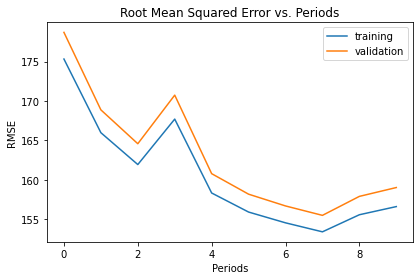

In [89]:
train_linear_regression_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    optimizer='FTRL',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Third Model: Additional Feature Transformation Techniques

We usually call numerical features *dense* features and non-numerical features *sparse* features. So far in our model we have been using dense (i.e. numerical) continuous features. There are other types of features, for instance, *dense discrete* features like ordinal features, *sparse discrete* features like ID strings, and *sparse continuous* feature like text and strings. Now we discuss several different ways to post process a feature of a certain type to feed it into our learner.

### One-Hot Encoding

For any discrete features, we can use One-Hot Encodings to transform them into proper feature vectors. For example, suppose we created a synthetic feature that can take any of the values `0`, `1` or `2`, and that we have a few training points:

| # | feature_value |
|---|---------------|
| 0 |             2 |
| 1 |             0 |
| 2 |             1 |

For each possible categorical value, we make a new **binary** feature of **real values** that can take one of just two possible values: 1.0 if the example has that value, and 0.0 if not. In the example above, the categorical feature would be converted into three features, and the training points now look like:

| # | feature_value_0 | feature_value_1 | feature_value_2 |
|---|-----------------|-----------------|-----------------|
| 0 |             0.0 |             0.0 |             1.0 |
| 1 |             1.0 |             0.0 |             0.0 |
| 2 |             0.0 |             1.0 |             0.0 |

One-Hot Encoding is especially useful when there is no ordering relationship among the orignal feature.

### Discretization/Bucketization
For dense continous features, it is often useful to discretize (a.k.a. bucketize) them into discrete values. The intuition for doing this is that, often time we do not care about the specific value of a feature, e.g. median income, but rather we care more about which bucket a particular income falls into. We map the feature to its bucket ID.

We can bucketize `population` into the following 3 buckets (for instance):
- `bucket_0` (`< 5000`): corresponding to less populated blocks
- `bucket_1` (`5000 - 25000`): corresponding to mid populated blocks
- `bucket_2` (`> 25000`): corresponding to highly populated blocks

Given the preceding bucket definitions, the following `population` vector:

    [[10001], [42004], [2500], [18000]]

becomes the following bucketized feature vector:

    [[1], [2], [0], [1]]

The feature values are now the bucket indices. Note that these indices are considered to be discrete features. Typically, these will be further converted in one-hot representations as above, but this is done transparently.

To define feature columns for bucketized features, instead of using `numeric_column`, we can use [`bucketized_column`](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column), **which takes a numeric column as input and transforms it to a bucketized feature** using the bucket boundaries specified in the `boundaries` argument. The following code defines bucketized feature columns for `households`, `longitude` and several other continous features; the `get_quantile_based_boundaries` function calculates boundaries based on quantiles, so that each bucket contains an equal number of elements.

In [0]:
def get_quantile_based_boundaries(feature_values, num_buckets):
  boundaries = np.arange(1.0, num_buckets) / num_buckets
  quantiles = feature_values.quantile(boundaries)
  return [quantiles[q] for q in quantiles.keys()]

def construct_bucketized_feature_columns(training_examples):
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person])
  
  return feature_columns

Let reload the training and validation data to get a clean start.

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

ERROR! Session/line number was not unique in database. History logging moved to new session 60
Training model...
RMSE (on training data):
  period 00 : 157.00
  period 01 : 104.75
  period 02 : 86.51
  period 03 : 76.59
  period 04 : 71.93
  period 05 : 70.12
  period 06 : 69.18
  period 07 : 68.68
  period 08 : 68.45
  period 09 : 68.22
Model training finished.


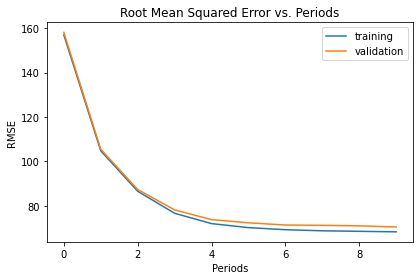

In [17]:
bucketized_feature_model = train_linear_regression_model(
    learning_rate=0.3,
    steps=500,
    batch_size=100,
    optimizer='SGD',
    feature_columns=construct_bucketized_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Feature Crosses
Crossing two (or more) features is a clever way to learn non-linear relations using a linear model. In our problem, if we just use the feature `latitude` for learning, the model might learn that city blocks at a particular latitude (or within a particular range of latitudes since we have bucketized it) are more likely to be expensive than others. Similarly for the feature `longitude`. However, if we cross `longitude` by `latitude`, the crossed feature represents a well defined city block. If the model learns that certain city blocks (within range of latitudes and longitudes) are more likely to be more expensive than others, it is a stronger signal than two features considered individually.

Currently, the feature columns API only supports discrete features for crosses. To cross two continuous values, like `latitude` or `longitude`, we can bucketize them.

If we cross the `latitude` and `longitude` features (supposing, for example, that `longitude` was bucketized into `2` buckets, while `latitude` has `3` buckets), we actually get six crossed binary features. Each of these features will get its own separate weight when we train the model.

In our following example, we are going to first bucketize the features and then perform different feature crosses.

In [0]:
def construct_crossed_feature_columns(training_examples):
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  households = tf.feature_column.numeric_column("households")
  longitude = tf.feature_column.numeric_column("longitude")
  latitude = tf.feature_column.numeric_column("latitude")
  housing_median_age = tf.feature_column.numeric_column("housing_median_age")
  median_income = tf.feature_column.numeric_column("median_income")
  rooms_per_person = tf.feature_column.numeric_column("rooms_per_person")
  
  # Divide households into 7 buckets.
  bucketized_households = tf.feature_column.bucketized_column(
    households, boundaries=get_quantile_based_boundaries(
      training_examples["households"], 7))

  # Divide longitude into 10 buckets.
  bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=get_quantile_based_boundaries(
      training_examples["longitude"], 10))
  
  # Divide latitude into 10 buckets.
  bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=get_quantile_based_boundaries(
      training_examples["latitude"], 10))

  # Divide housing_median_age into 7 buckets.
  bucketized_housing_median_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=get_quantile_based_boundaries(
      training_examples["housing_median_age"], 7))
  
  # Divide median_income into 7 buckets.
  bucketized_median_income = tf.feature_column.bucketized_column(
    median_income, boundaries=get_quantile_based_boundaries(
      training_examples["median_income"], 7))
  
  # Divide rooms_per_person into 7 buckets.
  bucketized_rooms_per_person = tf.feature_column.bucketized_column(
    rooms_per_person, boundaries=get_quantile_based_boundaries(
      training_examples["rooms_per_person"], 7))
  
  long_x_lat = tf.feature_column.crossed_column(
  set([bucketized_longitude, bucketized_latitude]), hash_bucket_size=1000) 
  
  feature_columns = set([
    bucketized_longitude,
    bucketized_latitude,
    bucketized_housing_median_age,
    bucketized_households,
    bucketized_median_income,
    bucketized_rooms_per_person,
    long_x_lat])
  
  return feature_columns

Training model...
RMSE (on training data):
  period 00 : 156.15
  period 01 : 103.05
  period 02 : 83.70
  period 03 : 73.12
  period 04 : 68.05
  period 05 : 65.90
  period 06 : 64.92
  period 07 : 64.24
  period 08 : 64.05
  period 09 : 63.56
Model training finished.


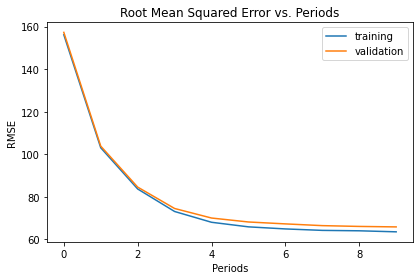

In [21]:
feature_cross_model_SGD = train_linear_regression_model(
    learning_rate=0.3,
    steps=500,
    batch_size=100,
    optimizer='SGD',
    feature_columns=construct_crossed_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 213.43
  period 01 : 202.48
  period 02 : 194.24
  period 03 : 187.42
  period 04 : 181.56
  period 05 : 176.34
  period 06 : 171.64
  period 07 : 167.37
  period 08 : 163.43
  period 09 : 159.79
Model training finished.


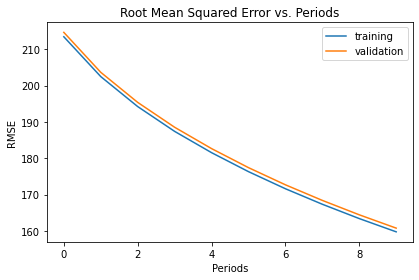

In [22]:
feature_cross_model_ftrl = train_linear_regression_model(
    learning_rate=0.3,
    steps=500,
    batch_size=100,
    optimizer='FTRL',
    feature_columns=construct_crossed_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Feature Hashing
We can think of One-Hot Encoding as providing a vocabulary file for all the possible values of a feature and then mapping each instance to its index in the vocabulary. One drawback is the lack of graceful hanlding of out-of-vocabulary values. A popular alternative is to hash the faeture values into a large, fixed dimensional space. The hash key is the feature value, the hash value is the index of the dimension.

### Embeddings
Embeddings are lower dimensional vector (i.e. numerical) representations of high dimensional (often times very sparse) features. There are many ways to _represent_ non-numerical features. For instance, in predicting sales price of a house, the state name is a useful categorical feature. To represent it as a numerical feature so that we can feed it into our model, we talked about using one-hot encodings that essentially uses a vocabulary that includes all the states. There are cases where the total number of distinct categories is simply too large such that one-hot encoding representations would not be feasible. We looked at the moving recommendation example where we would want to have a representation for movies that users have watched. In that training data there are over 1 millionn distinct movies. If we were to use the one-hot encoding represenation, each movie would need a vector of length 1 million to represent which would not be feasible to train. This is where we need embeddings.

Similarly, in many NLP problems, the features are words or documents, in which case the vocabulary size could also potentially be huge. Prior to word2vec, we would use TF.IDF or Bag-of-Words models to come up with vector representations. But with word2vec, we can obtain lower dimensional embeddings of words in a way that preserves their semantic meaning. We can then combine the word embeddings (e.g. simple average) to obtain document embeddings. 

From a neural network point of view, the edge weights connecting the input layer (the sparse representation) and the embedding layer are the **coordinates** in the embedded space.




## Reframing the Problem into Classification

As in the above, we're working with the [California housing data set](https://developers.google.com/machine-learning/crash-course/california-housing-data-description), but this time we will turn it into a binary classification problem by predicting whether a city block is a high-cost city block. We'll also revert to the default features, for now.

### Frame the Problem as Binary Classification

The target of our dataset is `median_house_value` which is a numeric (continuous-valued) feature. **We can create a boolean label by applying a threshold to this continuous value**.

Given features describing a city block, we wish to predict if it is a high-cost city block. To prepare the targets for train and eval data, we define a classification threshold of the 75%-ile for median house value (a value of approximately 265000). All house values above the threshold are labeled `1`, and all others are labeled `0`. We rewrite the `process_targets` function above.

In [0]:
def preprocess_targets_into_binary(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # median_house_value is above a set threshold.
  output_targets["median_house_value_is_high"] = (
    california_housing_dataframe["median_house_value"] > 265000).astype(float)
  return output_targets

We reload the datasets to get a clean start.

In [0]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets_into_binary(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets_into_binary(california_housing_dataframe.tail(5000))

Let's take a look at the training labels to see if we are doing the right thing:

In [28]:
training_targets.describe()

,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


### First Attemp Using Linear Regression for Binary Classification

We can first try to use linear regression with our binary labels and see if the predictions make sense.

Training model...
RMSE (on training data):
  period 00 : 0.45
  period 01 : 0.46
  period 02 : 0.46
  period 03 : 0.44
  period 04 : 0.45
  period 05 : 0.44
  period 06 : 0.44
  period 07 : 0.44
  period 08 : 0.44
  period 09 : 0.45
Model training finished.


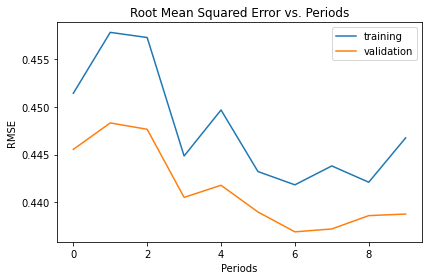

In [29]:
binary_classifier_with_linear_regression = train_linear_regression_model(
    learning_rate=0.000001,
    steps=200,
    batch_size=20,
    optimizer='SGD',
    feature_columns=construct_feature_columns(training_examples),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

`LinearRegressor` uses the L2 loss, which doesn't do a great job at penalizing misclassifications when the output is interpreted as a probability.  For example, there should be a huge difference whether a negative example is classified as positive with a probability of 0.9 vs 0.9999, but L2 loss doesn't strongly differentiate these cases.

In contrast, `LogLoss` penalizes these "confidence errors" much more heavily.  Remember, `LogLoss` is defined as:

$$Log Loss = \sum_{(x,y)\in D} -y \cdot log(y_{pred}) - (1 - y) \cdot log(1 - y_{pred})$$

### Logistic Regression

To use logistic regression, simply use [LinearClassifier](https://www.tensorflow.org/api_docs/python/tf/estimator/LinearClassifier) instead of `LinearRegressor`. 

**NOTE**: When running `train()` and `predict()` on a `LinearClassifier` model, you can access the real-valued predicted probabilities via the `"probabilities"` key in the returned dict—e.g., `predictions["probabilities"]`. Sklearn's [log_loss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) function is handy for calculating LogLoss using these probabilities.

In [0]:
def train_logistic_regression_model(
    learning_rate,
    steps,
    batch_size,
    feature_columns,
    optimizer,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    feature_columns: A `set` specifying the input feature columns to use.
    optimizer: A `String` to denote the type of optimizer we use. SGD by default.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object and figure out the columns to use on the fly.
  if optimizer == 'FTRL':
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate)
  else:
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(
      training_examples, 
      training_targets, 
      num_epochs=1, 
      shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(
      validation_examples, validation_targets, 
      num_epochs=1, 
      shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss (on training data):")
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.    
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_log_loss))
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print("Model training finished.")
  
  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.59
  period 01 : 0.58
  period 02 : 0.57
  period 03 : 0.55
  period 04 : 0.55
  period 05 : 0.54
  period 06 : 0.54
  period 07 : 0.54
  period 08 : 0.54
  period 09 : 0.53
Model training finished.


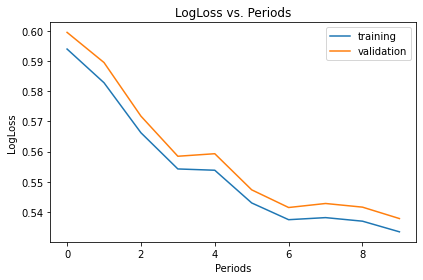

In [34]:
linear_classifier = train_logistic_regression_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    feature_columns=construct_feature_columns(training_examples),
    optimizer='SGD',
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Calculate Accuracy and plot a ROC Curve for the Validation Set

A few of the metrics useful for classification are the model [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification), the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the area under the ROC curve (AUC). We'll examine these metrics.

`LinearClassifier.evaluate` calculates useful metrics like accuracy and AUC.

In [36]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets, 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.70
Accuracy on the validation set: 0.75


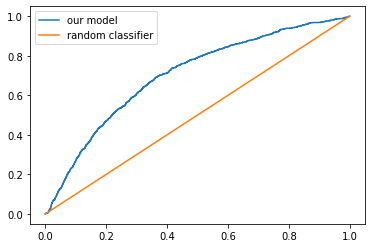

In [37]:
validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
# Get just the probabilities for the positive class.
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)